In [1]:
import sys
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import itertools

sys.path.append('../')

from sys_utils import load_model
from data_model_region import Region
from data_model import Individual
import typing as t
import random
from tqdm import tqdm



In [2]:
import plotly.express as px

#define function to calculate Gini coefficient
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

from scipy.stats import pearsonr

def get_stars(p):
    if  p<0.05:
        return '*'
    elif  p<0.01:
         return '**'
    elif  p<0.001:
        return '***'
    else:
        return ""

In [3]:
checkpoint_path = '../checkpoints_dev'

In [4]:
individuals = load_model(
        Individual, name=checkpoint_path + "/individuals.jsonl"
    )

In [5]:
#individuals_filtered = [x for x in individuals if x.raw_nationalities != None]

In [6]:

individuals_science = []

for ind in tqdm(individuals):
    for occupation in ind.id.occupations:
        if "science" in occupation.category:
            individuals_science.append(ind)
            break

100%|███████████████████████████████████████████████████| 225636/225636 [00:02<00:00, 102437.36it/s]


In [7]:
df_individuals = [
    {
        "wikidata_id": x.id.wikidata_id,
        "name": x.id.name,
        "birthyear": x.id.birthyear,
        "occupation":[y.name for y in x.id.occupations],
        "occupation_category":[y.category for y in x.id.occupations],
        'regions': x.regions
    }
    for x in individuals
]


df_individuals = pd.DataFrame(df_individuals)
#df_individuals = df_individuals.dropna()

In [8]:
test = df_individuals.explode(['occupation', 'occupation_category'])

In [9]:
len(df_individuals)

225636

In [10]:
test = test.explode('occupation_category')

In [11]:
test = test[test['occupation_category']=='science']

In [12]:
top_occupations= list(test.occupation.value_counts().head(50).index)

In [13]:
# only keep the top scientific occupation

In [106]:
df_regions = test.copy()
#df_regions["year"] = df_regions["range_impact"].apply(lambda x: [year for year in range(int(x[0]), int(x[1]) + 10, 10)])
df_regions = df_regions.explode('regions')

In [139]:
country = 're_low_countries'
min_individuals = 5
time = 10
n_top_occupation = 10
min_date = 800

In [140]:
top_occupations= list(test.occupation.value_counts().head(n_top_occupation).index)

df_stats = df_regions[df_regions['regions']==country].reset_index(drop=True)
df_stats = df_stats[df_stats['occupation'].isin(top_occupations)]

In [141]:

#df_stats = df_stats.explode('year')
df_stats['impact_year'] =  df_stats['birthyear'] + 35
df_stats['fifty'] =  df_stats['impact_year'].apply(lambda x : round(x / time) * time)
df_stats = df_stats[df_stats['fifty']<=1850]


df_index = df_stats.explode('occupation').reset_index(drop=True)
df_index = df_index[~df_index['occupation'].isin(['artist', 'university teacher', 'pedagogue', 'explorer', 'naturalist', 'scientist'])]


df_index = df_index.groupby(['fifty', 'occupation'])['wikidata_id'].count().reset_index()
df_index = df_index.sort_values(['fifty', 'wikidata_id'], ascending=(False, False))
#df_index = df_index.groupby('fifty').head(n_top_occupation).reset_index(drop=True)
#df_index = df_index[df_index['fifty']>=min_date]


df_index['time_sep'] = np.nan
df_index['time_sep'][df_index['fifty']<=1650] = 'before'
df_index['time_sep'][df_index['fifty']>1750] = 'after'

df_test = df_index.groupby(['time_sep', 'occupation'])['wikidata_id'].sum().reset_index()
df_count = df_index.groupby(['time_sep'])['wikidata_id'].sum().reset_index()
df_count.columns = ['time_sep', 'count_all']
df_test = pd.merge(df_count, df_test, on = 'time_sep')
df_test['percent'] = df_test['wikidata_id']/df_test['count_all']

df_final_group = df_test.groupby(['time_sep'])['percent'].apply(np.array).reset_index()
df_final_group['gini_coeff'] = df_final_group['percent'].apply(lambda x : gini(x))
df_final_group

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_7228/2768980868.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,time_sep,percent,gini_coeff
0,after,"[0.08071748878923767, 0.07623318385650224, 0.3...",0.289558
1,before,"[0.022058823529411766, 0.27941176470588236, 0....",0.491597


In [142]:
df_test

,time_sep,count_all,occupation,wikidata_id,percent
0,after,223,archaeologist,18,0.080717
1,after,223,astronomer,17,0.076233
2,after,223,botanist,76,0.340807
3,after,223,chemist,33,0.147982
4,after,223,entomologist,18,0.080717
5,after,223,mathematician,35,0.156951
6,after,223,physicist,26,0.116592
7,before,136,archaeologist,3,0.022059
8,before,136,astronomer,38,0.279412
9,before,136,botanist,20,0.147059


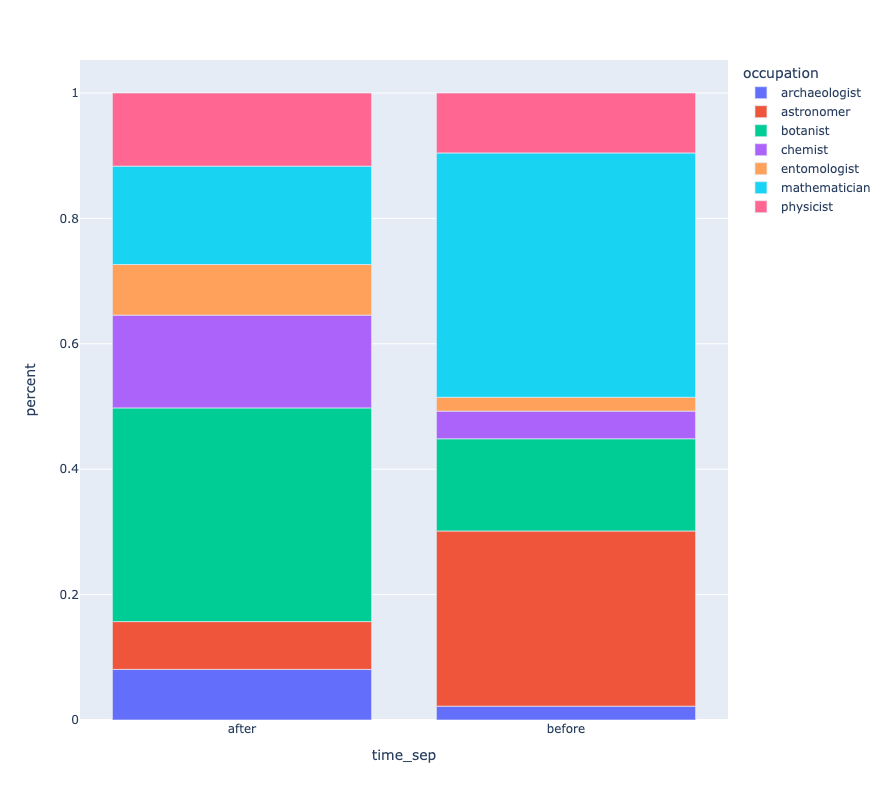

In [143]:
fig_bar = px.bar(df_test, x = 'time_sep', y = 'percent', color = 'occupation',  hover_name = 'occupation', height = 800)
fig_bar.show()

In [34]:

df_count = df_index.groupby(['fifty'])['wikidata_id'].sum().reset_index()
df_count.columns = ['fifty', 'count_all']
df_count = df_count[df_count['count_all']>=min_individuals]

df_final = pd.merge(df_count, df_index, on = 'fifty')
df_final['percent'] = df_final['wikidata_id']/df_final['count_all']

df_final_group = df_final.groupby(['fifty'])['percent'].apply(np.array).reset_index()
df_final_group['gini_coeff'] = df_final_group['percent'].apply(lambda x : gini(x))


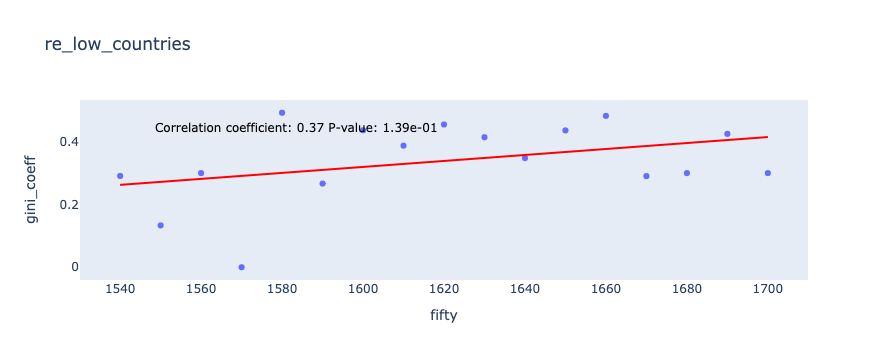

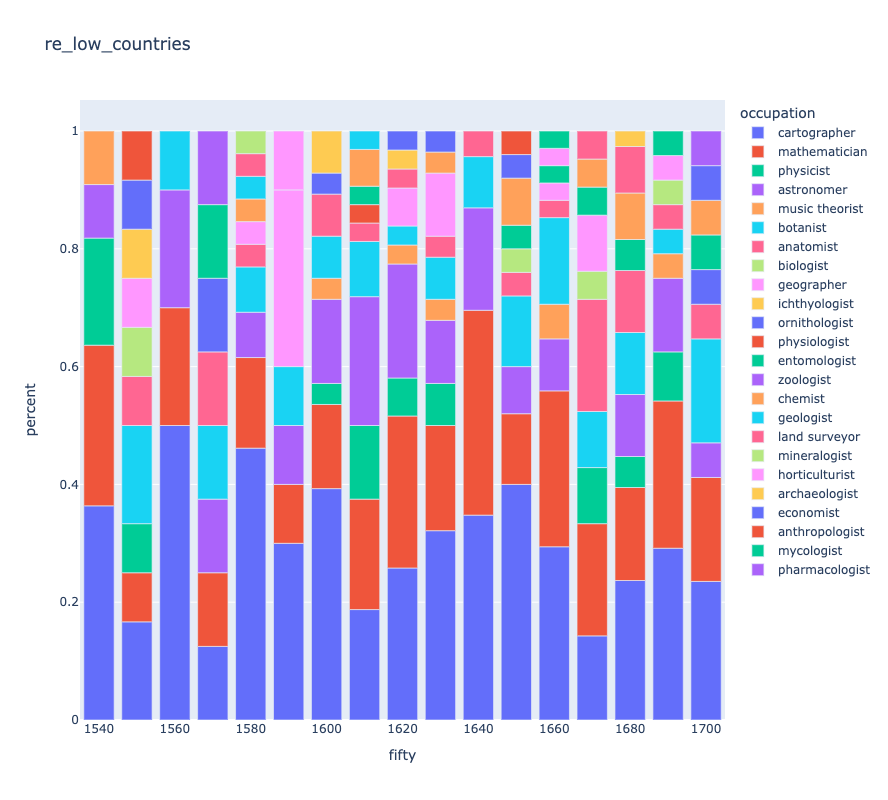

In [35]:


fig = px.scatter(df_final_group, x = 'fifty', 
                 y= 'gini_coeff', 
                 trendline="ols", 
                 title = country, 
                 trendline_color_override = 'red')

corr_coef, p_value =  pearsonr(df_final_group['fifty'], df_final_group['gini_coeff'])

# Add text annotation for correlation coefficient and p-value
fig.add_annotation(
    x=0.1, y=0.9,
    text=f'Correlation coefficient: {corr_coef:.2f}\nP-value: {float(p_value):.2e}{get_stars(p_value)}',
    showarrow=False,
    xref='paper', yref='paper',
    font=dict(size=12, color='black')
)

fig.update_xaxes(showgrid=False, showticklabels=True, zeroline=False)
fig.update_yaxes(showgrid=False, showticklabels=True, zeroline=False)
# Show plot
fig.show()


fig_bar = px.bar(df_final, x = 'fifty', y = 'percent', color = 'occupation', title = country, hover_name = 'occupation', height = 800)
fig_bar.show()

In [18]:
from functions_environment import get_maddison_data

data_path_environment = "../data_env"
df_maddison = get_maddison_data(data_path_environment)

#df_maddison_filtered = df_maddison[df_maddison['country_code_maddison'].isin(['ESP', 'ITA', 'FRA', 'DNK', 'JPN', "FRA"])]
#dict_countries = {'JPN':'re_japan', 'FRA':'re_france', 'ITA':'re_italy'}

#df_maddison_filtered['region_code'] = df_maddison_filtered['country_code_maddison'].apply(lambda x : dict_countries.get(x))
df_maddison_filtered = df_maddison[['year', 'gdp_per_capita', 'region_code']]
df_final_group['region_code'] = country

In [19]:
df_maddison[df_maddison['region_code']=='re_japan'].head(10)

,region_code,country_code_maddison,year,gdp_per_capita
7706,re_japan,JPN,730,598
7707,re_japan,JPN,1000,1010
7708,re_japan,JPN,1120,927
7709,re_japan,JPN,1280,841
7710,re_japan,JPN,1450,867
7711,re_japan,JPN,1600,1061
7712,re_japan,JPN,1700,1073
7713,re_japan,JPN,1721,1073
7714,re_japan,JPN,1750,953
7715,re_japan,JPN,1800,1317


In [20]:

# create a new index with yearly values
yearly_index = pd.Index(range(df_final_group.index.min(), df_stats.index.max() + 1), name='fifty')
# reindex the DataFrame with the yearly index and interpolate the missing values
interpolated_df = df_final_group.reindex(yearly_index).interpolate(method='linear')
interpolated_df['region_code']=country
interpolated_df = interpolated_df[['fifty', 'gini_coeff', 'region_code']]
interpolated_df.columns = ['year', 'gini_coeff', 'region_code']

from sklearn import preprocessing

final_stats = pd.merge(interpolated_df, df_maddison_filtered, on = ['year', 'region_code'])
final_stats = final_stats.sort_values('year')


min_max_scaler = preprocessing.MinMaxScaler()
final_stats['gini_coeff_norm'] =  min_max_scaler.fit_transform(final_stats[['gini_coeff']])
final_stats['gdp_per_capita_norm'] =  min_max_scaler.fit_transform(final_stats[['gdp_per_capita']])
final_stats = final_stats.drop_duplicates()

fig_stats = px.scatter(final_stats, x = 'gini_coeff_norm', y = 'gdp_per_capita_norm', trendline = 'ols')
fig_stats.show()

import statsmodels.formula.api as smf

# load the data into a DataFrame

# perform a multiple regression analysis with 'country' as a control variable
model = smf.ols('gini_coeff_norm ~ gdp_per_capita_norm + year', data=final_stats)
results = model.fit()
print(results.summary())

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.